In [2]:
!pip install celluloid

MovieWriter imagemagick unavailable; using Pillow instead.


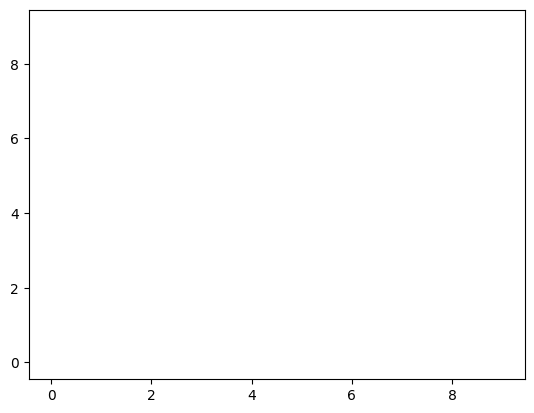

In [3]:
from matplotlib import pyplot as plt
from celluloid import Camera
 
fig = plt.figure()
camera = Camera(fig)
 
for i in range(10):
    plt.plot([i] * 10)
    camera.snap()
 
animation = camera.animate()
animation.save('celluloid_minimal.gif', writer = 'imagemagick')

In [1]:
%load_ext autoreload
%autoreload 2

warrior:  (0, 1.5)
knight:  (0, 1.5)
warrior:  (0, 2.5)
knight:  (0, 2.5)
warrior:  (0, 3.5)
archer:  (0, 3.5)
warrior:  (8, 1.5)
knight:  (8, 1.5)
warrior:  (8, 2.5)
knight:  (8, 2.5)
warrior:  (8, 3.5)
archer:  (8, 3.5)
snap!
i:  0
i:  1
i:  2
i:  3
i:  4
i:  5
i:  6
i:  7
i:  8
i:  9


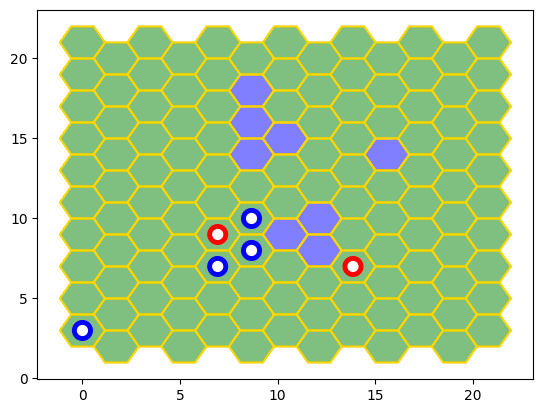

In [7]:
from Game import Game
from objects.Warriors import Archer, Knight
from graphics.MatplotlibRenderer import MatplotlibRenderer
from map.Map import Map
from Config import Config

m = Map('static/map.json')
teams = [
            [Knight(pos=(0, 1.5)), Knight(pos=(0, 2.5)), Archer(pos=(0, 3.5))], 
            [Knight(pos=(8, 1.5)), Knight(pos=(8, 2.5)), Archer(pos=(8, 3.5))], 
        ]
config = Config('static/config.json')

plt_assets = {
    'surface' : {
        'none'  : {
            'color' : 'white'
        },
        'water' : {
            'color' : 'blue'
        },
        'ground' : {
            'color' : 'brown'
        },
        'grass' : {
            'color' : 'green'
        }
    },
    'warriors': {
        'archer' : 'red',
        'knight' : 'blue'
    }
}

renderer = MatplotlibRenderer(plt_assets)
game = Game(teams, m, config)
data = game.reset(max_iter=1000, record=True, renderer=renderer)
for i in range(10):
    print("i: ", i)
    game.step({'type' : 'move', 'params' : {'pos' : (5, 5)}})
renderer.save()

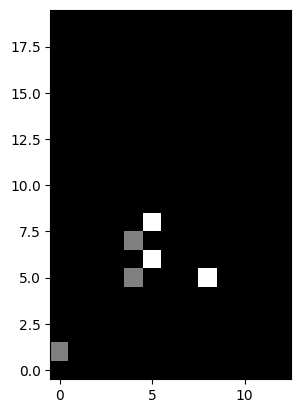

In [8]:
import matplotlib.pyplot as plt

# config = Config('static/config.json')
# game = Game(teams, m, config)
mask = game.observe() # .reset(max_iter=1000, record=False, renderer=None)

plt.imshow(mask[4], cmap='gray', interpolation='nearest')
plt.gca().invert_yaxis()

In [6]:
[w.health for team in teams for w in team]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

tensor(405) 405 {'type': 'attack', 'params': {'pos': (2, tensor(6.5000))}}


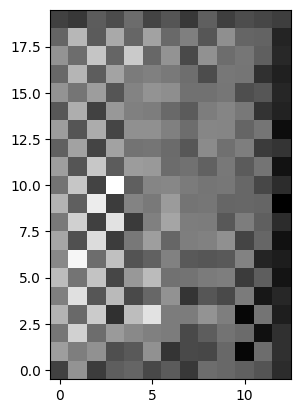

In [45]:
from Brain import ArcherBrain, PreNet, Distribution
import matplotlib.pyplot as plt

h, w = game.field.hex_field.get_size()
w, h = int(w), int((h-0.5)*2)+1
brain = ArcherBrain(prenet=PreNet(h, w), return_dist=True)
dist = brain(game.observe())

plt.imshow(dist.dist['move']['heat_map'].detach().numpy(), cmap='gray', interpolation='nearest')
plt.gca().invert_yaxis()

# res['params']['heat_map'][:10,:10]

action_ind = dist.sample().argmax()
action = dist.decode_action(action_ind)
action_ind_new = dist.encode_action(action)

print(action_ind, action_ind_new, action)

In [21]:
from map.Map import serializable2map, map2serializable
import json


data = []
with open('static/map.copy.json', 'r', encoding='utf-8') as file:
    data = json.load(file)
with open('static/map.json', 'w', encoding='utf-8') as file:
    m = serializable2map(data)
    for k, item in m['surface'].items():
        m['surface'][k]['speed'] = 0. if m['surface'][k]['s_type'] == 'water' else 1.
    m = map2serializable(m)
    json.dump(m, file)

In [3]:
game.warrior_pos

{(0, 1.5), (0.0, 4.5), (0.0, 5.5), (4.0, 1.5), (5.0, 2.0), (8, 1.5)}

# PPO

In [10]:
from training.PolicyValueNetwork import PolicyValueNetwork
# input:
#     states - tensor, (batch_size x features)
# output:
#     distribution
#     V - tensor, critic estimation, (batch_size)

In [124]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class Policy:
    def __init__(self, model):
        self.model = model.to(device=DEVICE)

    def act(self, inputs, training=False):
        """
        input:
            inputs - numpy array if training is False, otherwise tensor, (batch_size x features)
            training - flag, bool
        output:
            if training is True, dict containing keys ['actions', 'log_probs', 'values']:
                `distribution`
                'values' - critic estimations, tensor, (batch_size)
            if training is False, dict containing keys ['actions', 'log_probs', 'values']:
                'actions' - selected actions, numpy, (batch_size)
                'log_probs' - log probs of selected actions, numpy, (batch_size)
                'values' - critic estimations, numpy, (batch_size)
        """
        # if training is false, input is numpy
        if not training:
            inputs = torch.FloatTensor(inputs).to(DEVICE)

        dist, values = self.model(inputs)
        actions = dist.sample()
        log_probs = dist.log_prob(actions)
        values = values.flatten()

        if training:
            return {
                "dist": dist,
                "values": values,
            }

        else:
            return {
                "dist": dist,
                "actions": actions.cpu().detach().numpy(),
                "log_probs": log_probs.cpu().detach().numpy(),
                "values": values.cpu().detach().numpy(),
            }


In [125]:
from Brain import ArcherBrain, KnightBrain, ValueNet
from training.GameRunner import GameRunner
from training.PPO import AsArray
from Game import Game

config = Config('static/config.json')
game = Game(teams, m, config)
mask = game.reset(max_iter=1000, record=False, renderer=None)

brain = ArcherBrain(prenet=PreNet(h, w), return_dist=True)
value_net = ValueNet(prenet=PreNet(h, w))
model = PolicyValueNetwork(brain, value_net).to(DEVICE)
policy = Policy(model)
runner = GameRunner(game, policy, nsteps=5, transforms=[AsArray()])
trajectory = runner.get_next()
print(trajectory.keys())

dict_keys(['actions', 'dist', 'log_probs', 'values', 'observations', 'rewards', 'dones'])


In [ ]:
print(type(trajectory['actions']), trajectory['actions'])
print(type(trajectory['dist']), trajectory['dist'].shape)
print(type(trajectory['log_probs']), trajectory['log_probs'])
print(type(trajectory['values']), trajectory['values'])
print(type(trajectory['observations']), trajectory['observations'].shape)
print(type(trajectory['rewards']), trajectory['rewards'])
print(type(trajectory['dones']), trajectory['dones'])
{k: v.shape for k, v in trajectory.items()}

<class 'numpy.ndarray'> [[0.10933605]
 [0.13174143]
 [0.15743752]
 [0.15743752]
 [0.10652921]]
<class 'numpy.ndarray'> (5, 5, 20, 13)
<class 'numpy.ndarray'> [0. 0. 0. 0. 0.]
<class 'numpy.ndarray'> [False False False False False]


{'actions': (5, 520),
 'dist': (5,),
 'log_probs': (5,),
 'values': (5, 1),
 'observations': (5, 5, 20, 13),
 'rewards': (5,),
 'dones': (5,)}

In [77]:
from training.GAE import GAE

In [123]:
from training.PPO import Sampler, NormalizeAdvantages, PyTorchify, make_ppo_sampler, PPO

In [ ]:
model = PolicyValueNetwork(brain, value_net).to(DEVICE)
policy = Policy(model)
sampler = make_ppo_sampler(game, policy, num_runner_steps=128, num_epochs=5)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, eps=1e-05)
ppo = PPO(policy, optimizer, sampler)

import tqdm
NUM_ITERATIONS = 100

for iteration in tqdm.tqdm(range(NUM_ITERATIONS)):
    for batch in sampler.get_next():
        ppo.step(batch)

    # print(f"Iteration {iteration + 1}/{NUM_ITERATIONS} completed")

In [ ]:
import numpy as np
def evaluate(env, policy, n_games=1, t_max=1000):
    """
    Plays n_games and returns rewards and rendered games
    """
    rewards = []

    for _ in range(n_games):
        s = env.reset()

        R = 0
        for _ in range(t_max):
            action = policy.act(np.array([s]))["actions"][0]

            _, s, done = env.step(action)

            # remember that we used a wrapper that normalizes reward
            # original reward per step comes here
            R += info["original reward"]

            if done:
                break

        rewards.append(R)

    return np.array(rewards)

In [130]:
# evaluation will take some time!
sessions = evaluate(game, policy, n_games=20)
score = sessions.mean()
print(f"Your score: {score}")

ValueError: not enough values to unpack (expected 4, got 3)